In [32]:
import os
import re
from collections import Counter
from pathlib import Path

import pandas as pd
import scanpy as sc
import tifffile
from PIL import Image

In [33]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
%autoreload 2

In [35]:
from violet.utils.preprocessing import process_adata, extract_st_tiles

In [36]:
filemap = pd.read_csv('/home/estorrs/spatial-analysis/data/sample_map.txt', sep='\t')
filemap = filemap[~pd.isnull(filemap['highres_image'])]
filemap

,sample_id,spaceranger_output,highres_image,disease
0,HT206B1_H8_U2,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
1,HT206B1_H8_U3,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
2,HT206B1_H8_U4,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
3,HT206B1_H8_U5,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
5,HT235B1_H1_U1,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
...,...,...,...,...
85,NMK_20201012,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/m...,mouse_kidney
86,AKICL_14w,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/m...,mouse_kidney
87,AKI_M_14w,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/m...,mouse_kidney
88,SP1896H1_U1,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/i...,normal_stomach


In [37]:
Counter(filemap['disease']).most_common()

[('mouse_kidney', 24),
 ('brca', 22),
 ('pdac', 15),
 ('co', 7),
 ('co_met', 6),
 ('cholangiocarcinoma', 2),
 ('ccrcc', 2),
 ('lusl_pdx', 2),
 ('ucec', 2),
 ('brca_met', 1),
 ('gbm', 1),
 ('mouse_bladder', 1),
 ('mouse_prostate', 1),
 ('normal_stomach', 1),
 ('normal_liver', 1)]

In [38]:
keep = [d for d in set(filemap['disease'])
        if 'mouse' not in d
        if 'pdx' not in d]
keep

['cholangiocarcinoma',
 'ucec',
 'brca_met',
 'pdac',
 'normal_stomach',
 'normal_liver',
 'gbm',
 'co_met',
 'ccrcc',
 'co',
 'brca']

In [39]:
# keep = ['co']
filemap = filemap[[True if d in keep else False
                  for d in filemap['disease']]]
filemap

,sample_id,spaceranger_output,highres_image,disease
0,HT206B1_H8_U2,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
1,HT206B1_H8_U3,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
2,HT206B1_H8_U4,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
3,HT206B1_H8_U5,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
5,HT235B1_H1_U1,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
7,HT235B1_H2_U1,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
8,HT235B1_H3_U1,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
9,HT243B1_H3A2_U1,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
10,HT243B1_H3A2_U2,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
11,HT243B1_H3A2_U3,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca


In [40]:
data_map = {row['sample_id']: {'spatial': row['spaceranger_output'], 'tif': row['highres_image']}
            for i, row in filemap.iterrows()}

In [41]:
imgs, img_ids = extract_st_tiles(data_map)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Vari

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Vari

In [44]:
len(imgs)

210756

In [45]:
img_ids[:2], imgs[:2]

(['C3L00671_U1_AAACAAGTATCTCCCA-1', 'C3L00671_U1_AAACATTTCCCGGATT-1'],
 [array([[[162, 143, 161],
          [181, 133, 193],
          [191, 111, 188],
          ...,
          [248, 253, 213],
          [212, 235, 175],
          [148, 169, 134]],
  
         [[183, 181, 186],
          [181, 159, 214],
          [183, 132, 212],
          ...,
          [252, 253, 217],
          [231, 249, 197],
          [144, 164, 133]],
  
         [[210, 221, 206],
          [188, 190, 228],
          [172, 148, 229],
          ...,
          [252, 253, 225],
          [216, 233, 193],
          [127, 142, 126]],
  
         ...,
  
         [[206, 243, 237],
          [215, 242, 244],
          [227, 241, 255],
          ...,
          [185, 198, 242],
          [245, 249, 255],
          [253, 248, 255]],
  
         [[232, 253, 255],
          [238, 253, 255],
          [243, 253, 251],
          ...,
          [144, 156, 200],
          [214, 222, 251],
          [250, 247, 255]],
  
       

In [16]:
output_dir = '/home/estorrs/violet/data/st/human_he_06252021'
samples = sorted(data_map.keys())
for sample in samples:
    Path(os.path.join(output_dir, 'train', sample)).mkdir(parents=True, exist_ok=True)
    Path(os.path.join(output_dir, 'val', sample)).mkdir(parents=True, exist_ok=True)

In [17]:
# picking some random validation images
val_samples = ['HT265B1_H1A2_U1', 'HT230C1_U1', 'HT264P1_H2A2_U1', 'UCEC4723']

In [19]:
for img, img_id in zip(imgs, img_ids):
    sample = '_'.join(img_id.split('_')[:-1])
    im = Image.fromarray(img)
    
    if sample in val_samples:
        im.save(os.path.join(output_dir, 'val', sample, f'{img_id}.jpeg'))
    else:
        im.save(os.path.join(output_dir, 'train', sample, f'{img_id}.jpeg'))

###### spot check location of image

In [21]:
import matplotlib.pyplot as plt

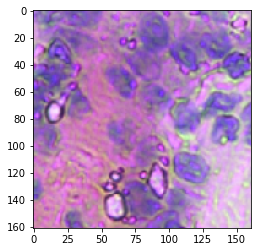

In [52]:
s = 192487
plt.imshow(imgs[s])

In [48]:
img_ids[s]

'HT112C1_U1_AAACTCGGTTCGCAAT-1'

In [47]:
[(i, x) for i, x in enumerate(img_ids) if 'RCC' in x][:5]

[(192483, 'RCC001_AAACAAGTATCTCCCA-1'),
 (192484, 'RCC001_AAACACCAATAACTGC-1'),
 (192485, 'RCC001_AAACAGAGCGACTCCT-1'),
 (192486, 'RCC001_AAACAGCTTTCAGAAG-1'),
 (192487, 'RCC001_AAACAGGGTCTATATT-1')]

In [27]:
s_id = '_'.join(img_ids[s].split('_')[:-1])
a = sc.read_visium(filemap.set_index('sample_id').loc[s_id, 'spaceranger_output'])
a.obs.index = [f'{s_id}_{i}' for i in a.obs.index]
a.obs['highlight'] = ['A' if i==img_ids[s] else 'B'
                     for i in a.obs.index]
sc.pl.spatial(a, color='highlight')

NameError: name 's' is not defined

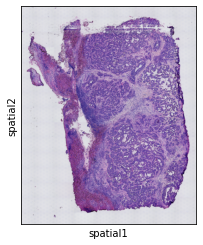

In [50]:
sc.pl.spatial(a)

In [31]:
a = sc.read_visium(filemap.set_index('sample_id').loc['NMK_20201012', 'spaceranger_output'])
a.uns['spatial'][list(a.uns['spatial'].keys())[0]]['scalefactors']['spot_diameter_fullres']

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


181.48018639605988

In [ ]:
sc.pl.spatial(a)

In [29]:
list(a.uns['spatial'].keys())[0]

'Colorectal_112C1_1'

In [30]:
a.uns['spatial'][list(a.uns['spatial'].keys())[0]]

{'images': {'hires': array([[[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
  
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
  
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
  
         ...,
  
         [[0.69803923, 0.69803923, 0.698039